## Demo Python-Notebook to the paper "Online distributed waveform-synchronization for acoustic sensor networks with dynamic topology" written by A. Chinaev, N. Knäpper \& G. Enzner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from asn_testbed.database.database import AsyncWASN
from asn_testbed.database.handler import PositionHandler, TimeHandler

import sys
sys.path.append('modules/')
from plot_utils import *
from audio_reader import AudioReader # customized, previously part of asn_testbed
from sro_estimation import NetworkController
from topology_tools import TopologyManager

## 1. Demo configuration

In [2]:
DATA_ROOT = '../2023_ASMP/data_asmp/' # signal database incl. metadata

sig_len_sec = 250
fs_Hz = 16e3
frame_len = 2**11
testbed_json = DATA_ROOT+'json/testbed.json'
json_pos = DATA_ROOT+'json/positions.json'
room_model = DATA_ROOT+'room_model.stl'
n_frames = int((sig_len_sec*fs_Hz)/frame_len) 
position_handler = PositionHandler(json_pos)
time_handler = TimeHandler()
example_db = AsyncWASN(testbed_json, position_handler)
examples = example_db.get_scenario('examples')
ex_id = 0
node_coord = lambda nid: position_handler.get_node_pos(examples[ex_id]['nodes']["node_"+str(nid)]['pos_id'])['coordinates']

### Configure WASN topology and network change

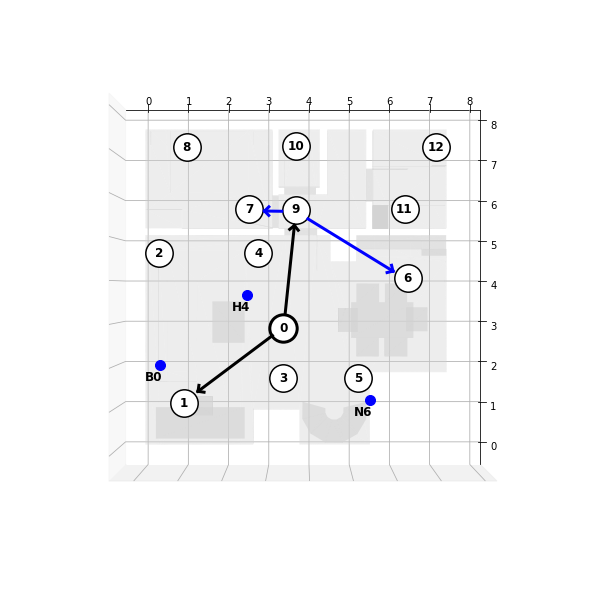

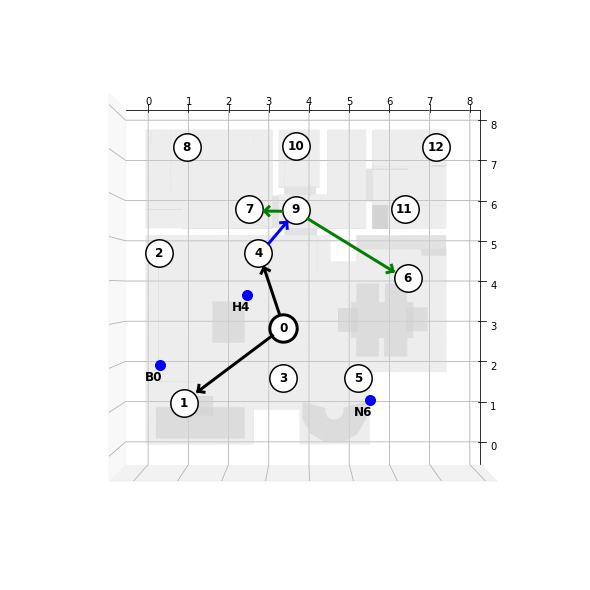

In [6]:
# Choose participating nodes in initial WASN
node_ids_start = [0, 1, 6, 7, 9]

# Define time of network change
Tc = 100

# Obtain initial topology
TopMng = TopologyManager({nid: node_coord(nid) for nid in node_ids_start})
nodes_levels_before = TopMng.nodes_levels

# Obtain modified topology by applying specific network change
TopMng.add_nodes({4: node_coord(4)})
#TopMng.set_node_links([[6, 9]], False)
#TopMng.remove_nodes([0])
nodes_levels_after = TopMng.nodes_levels


# Determine selection masks...
nodes_select = TopologyManager.get_unique_node_list(nodes_levels_before+nodes_levels_after)
nodes_select_before = TopologyManager.get_unique_node_list(nodes_levels_before)
nodes_select_after = TopologyManager.get_unique_node_list(nodes_levels_after)
n_nodes = len(nodes_select)
n_async_nodes = n_nodes-1
select_before = [nodes_select.index(node_id) for node_id in nodes_select_before]
select_after = [nodes_select.index(node_id) for node_id in nodes_select_after]

# Plot topology before and after network change
plot_positions_and_topology(examples[ex_id], room_model, sig_len_sec, position_handler, nodes_levels_before)
plot_positions_and_topology(examples[ex_id], room_model, sig_len_sec, position_handler, nodes_levels_after)


## 2. Load Audio- and Metadata

In [4]:
# LOAD AUDIO
audio_reader = AudioReader(data_root=DATA_ROOT, block_length=frame_len, block_shift=frame_len, node_ids=nodes_select, mic_ids='mic_0')
examples = examples.map(audio_reader)

frame_len = np.shape(examples[ex_id]['audio'][nodes_select[0]]['mic_0'])[1]
n_frames_max = min([np.shape(examples[ex_id]['audio'][node_id]['mic_0'])[0] for node_id in nodes_select])
n_frames = int((sig_len_sec*fs_Hz)/frame_len) 
if n_frames > n_frames_max:
    n_frames = n_frames_max
    sig_len_prev = sig_len_sec
    sig_len_sec = n_frames*frame_len/fs_Hz
    print('Warning: Audio signals too short for desired simulation length of ', str(sig_len_prev), 's. \nReduced simulation length to ', str(sig_len_sec), 's')
signals = np.stack(tuple(examples[ex_id]['audio'][node]['mic_0'][:n_frames,:] for node in nodes_select), axis=2)

# GET GROUND TRUTH SRO (AND STO)
SRO_true = np.zeros((n_nodes))
for i in range(1, len(nodes_select)):
    SRO_true[i] = examples[ex_id]['nodes'][nodes_select[i]]['sro'] - examples[ex_id]['nodes'][nodes_select[0]]['sro']

### Plot source activity and scene diary

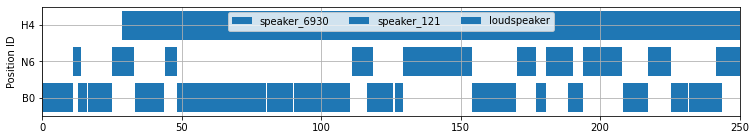

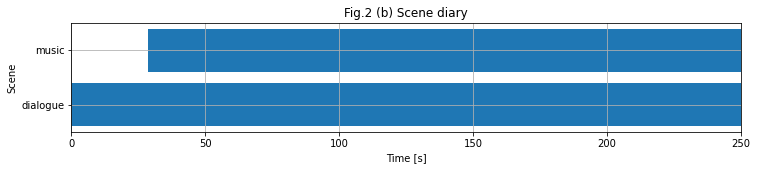

In [5]:
plot_pos_hist(examples[ex_id]['src_diary'], sig_len_sec)
plot_scene_diary(examples[ex_id]['scene_diary'], sig_len_sec)

## 3. Perform WASN simulation

In [11]:
# Prepare results
signals_synced = np.zeros_like(signals)
signals_synced[:,:,0] = signals[:,:,0] # ref signal is already sync
SRO_est = np.empty((n_frames, n_nodes))
SRO_est[:] = np.nan
dSRO_est = np.empty((n_frames, n_nodes))
dSRO_est[:] = np.nan

# Simulate WASN operation...
Net = NetworkController(nodes_levels_before, frame_len, resamplerType='stft')
Tc_frame_idx = int(np.round(Tc*fs_Hz/frame_len))
n_frames = np.shape(signals)[0]
for frame_idx in tqdm(range(n_frames)):

    if frame_idx == Tc_frame_idx:
        Net.restructure(nodes_levels_after)
        print('WASN restructered!')

    select = select_before if frame_idx < Tc_frame_idx else select_after
    select_out = select

    SRO_est_, dSRO_est_, frames_synced = Net.process(signals[frame_idx, :, select].T)
    SRO_est[frame_idx, select_out] = SRO_est_
    dSRO_est[frame_idx, select_out] = dSRO_est_
    signals_synced[frame_idx,:,0] = signals[frame_idx, :, 0] # from root node
    signals_synced[frame_idx,:, select] = frames_synced.T


Net.shutdown()

 40%|████      | 789/1953 [00:13<00:20, 55.95it/s]

WASN restructered!


100%|██████████| 1953/1953 [00:37<00:00, 51.64it/s]


### Plot SRO trajectories

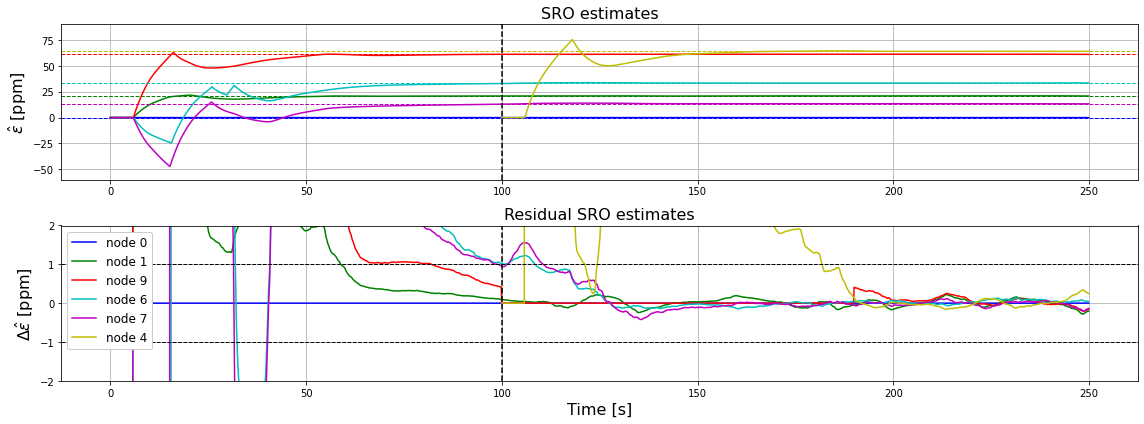

In [12]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

for i in range(n_nodes):
    mask = np.isfinite(SRO_est[:,i])
    time_ax = np.arange(len(SRO_est[:,i]))*(frame_len/fs_Hz)
    axs[0].plot(time_ax[mask], SRO_est[mask,i], label=' '.join(nodes_select[i].split('_')), color=colors[i%len(colors)])
    axs[0].axhline(y=SRO_true[i], linestyle='--', color=colors[i%len(colors)], lw=1)
axs[0].set_title('SRO estimates', fontsize=16)
axs[0].set_ylabel(r'$\hat{\varepsilon}$ [ppm]', fontsize=16)
axs[0].set_ylim((-60, 90))       
axs[0].grid()
axs[0].axvline(x=Tc, linestyle='--', color='k') 


for i in range(n_nodes):
    mask = np.isfinite(dSRO_est[:,i]) 
    time_ax = np.arange(len(dSRO_est[:,i]))*(frame_len/fs_Hz)
    axs[1].plot(time_ax[mask], dSRO_est[mask,i], label=' '.join(nodes_select[i].split('_')), color=colors[i%len(colors)])
axs[1].legend(loc='upper left', fontsize=12, framealpha=1)
axs[1].set_title('Residual SRO estimates', fontsize=16)
axs[1].axhline(-1, linestyle='--', color='k', lw=1)
axs[1].axhline(1, linestyle='--', color='k', lw=1)
axs[1].set_ylabel(r'$\Delta\hat{\varepsilon}$ [ppm]', fontsize=16)
axs[1].set_ylim((-2, 2)); axs[1].grid()
axs[-1].set_xlabel('Time [s]', fontsize=16)
axs[1].axvline(x=Tc, linestyle='--', color='k') 

plt.tight_layout(); 
plt.show()